In [16]:
from array import array
from settings import gauss_exp
from settings import PROTON_THRESHOLD, ELECTRON_THRESHOLD
import math
import ROOT
ROOT.gStyle.SetPalette(ROOT.kBird)
ROOT.gROOT.ProcessLine("gErrorIgnoreLevel = 2002;")

2002

In [13]:
import electron_res as e
import importlib    # This command makes sure we load the last version of the module
importlib.reload(e) # No need to restart the kernel after modifications

<module 'electron_res' from '/Users/soleti/uboone/nue_selection_plots/electron_res.py'>

In [18]:
n_bins = 10
max_energy = 2
scale = 1
h_reco_true, h_true, h_reco, h_reco_true_corr, h_reco_corr = e.deposited_calibration(
    "data_files/mc_nue_sbnfit", n_bins, max_energy, scale, (1, -0.003),
    (0.78, -0.037), (9.80163e-01, -2.85112e-02))

 FCN=0.0425752 FROM MIGRAD    STATUS=CONVERGED      47 CALLS          48 TOTAL
                     EDM=7.05158e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  m            9.50456e-01   1.72682e-01   4.40086e-04  -3.61174e-04
   2  q            1.16691e-02   1.41307e-01   1.92364e-04  -9.74175e-04


Info in ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


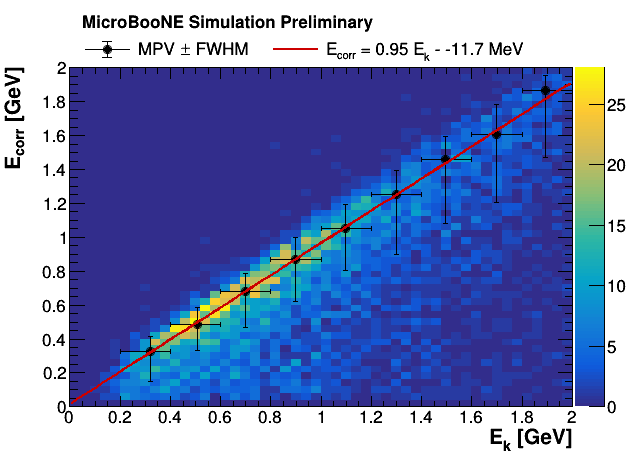

In [19]:
c = ROOT.TCanvas("c", "Neutrino calibration", 640, 480)
g_reco_true, x_values, x_errs_low, x_errs_high = e.calibration_graph_deposited(h_reco, h_true)
h_reco_true_drawn = h_reco_true.Clone()
h_reco_true_drawn.Rebin2D(4, 4)
h_reco_true_drawn.GetXaxis().SetRangeUser(0, 2)
h_reco_true_drawn.GetYaxis().SetRangeUser(0, 2)
h_reco_true_drawn.Draw("colz")
h_reco_true_drawn.SetMinimum(-0.001)
g_reco_true.SetMarkerStyle(20)
g_reco_true.Draw("p same")

f_line = ROOT.TF1("f_line", "[0]*x+[1]", 0.185, 2)
f_line.SetParNames("m", "q")
f_line.SetParLimits(0, 0.8, 1.0)
f_line.SetParLimits(1, -0.45, 0.1)
l_p_true_reco = ROOT.TLegend(0.12, 0.86, 0.900, 0.98)
l_p_true_reco.SetHeader("MicroBooNE Simulation Preliminary")
l_p_true_reco.SetNColumns(2)
l_p_true_reco.SetTextSize(18)
header = l_p_true_reco.GetListOfPrimitives().First()
header.SetTextFont(63)
l_p_true_reco.AddEntry(g_reco_true, "MPV #pm FWHM", "lep")
g_reco_true.Fit(f_line, "R", "", 0, 2.5)
m, q = f_line.GetParameter(0), f_line.GetParameter(1)
l_p_true_reco.AddEntry(
    f_line, "E_{corr} = %.2f E_{k} - %.1f MeV" % (m, -q * 1000), "l")
f_line.SetLineColor(ROOT.kRed + 1)
f_line.Draw("same")
l_p_true_reco.Draw()
c.SetLeftMargin(0.11)
c.SetTopMargin(0.15)
c.Draw()
c.SaveAs("plots/deposited_calib.pdf")

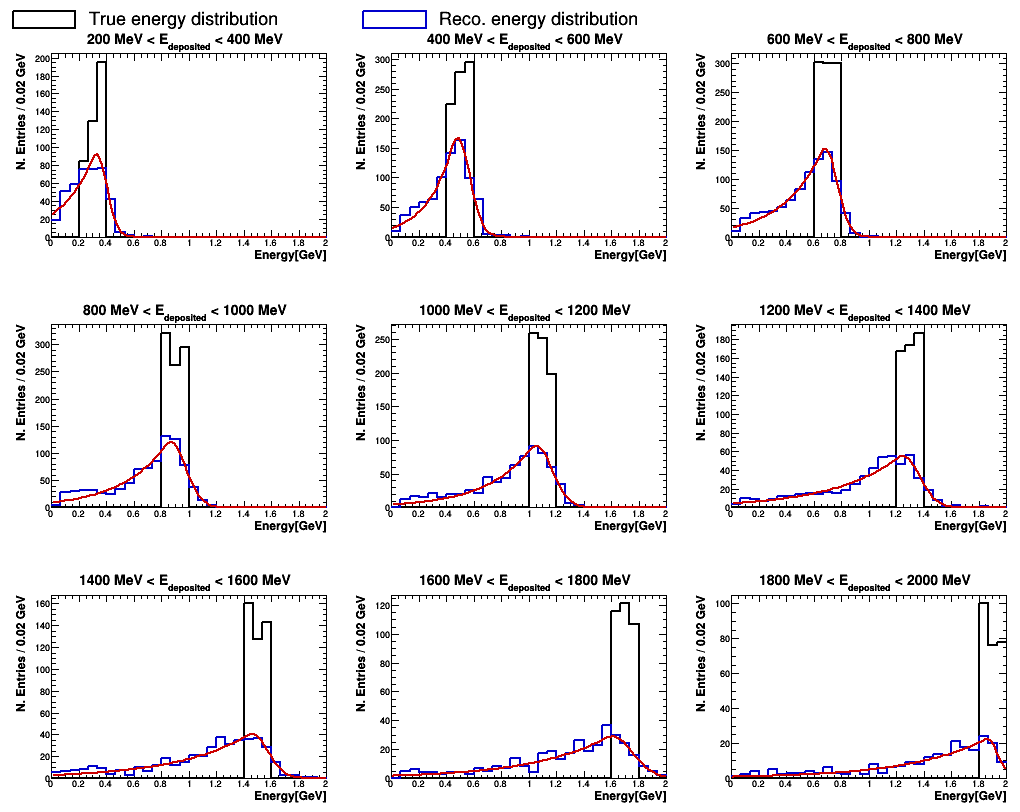

In [20]:
c_spectra = ROOT.TCanvas("c_spectra", "Spectra", 1024, 840)
c_spectra.cd()
ROOT.gPad.SetTopMargin(0.2)
c_spectra.Divide(3,3)
leg = ROOT.TLegend(0, 0.96, 0.7, 0.99)
leg.SetNColumns(2)
h_true[0].SetLineColor(1)
leg.AddEntry(h_true[0], "True energy distribution", "f")
leg.AddEntry(h_reco[0], "Reco. energy distribution", "f")
obj = []
ROOT.gStyle.SetOptTitle(0)
for i in range(1, n_bins):
    c_spectra.cd(i)
    ROOT.gPad.SetLeftMargin(0.13)
    ROOT.gPad.SetRightMargin(0.01)
    ROOT.gPad.SetTopMargin(0.18)
    pt = ROOT.TPaveText(0.1, 0.83, 1, 0.9, "NDC")
    pt.AddText(h_true[i].GetTitle())
    pt.SetBorderSize(0)
    pt.SetFillStyle(0)
    h_true[i].Draw()
    h_true[i].SetLineColor(1)
    h_reco[i].Draw("same")
    pt.Draw()
    obj.append(pt)
c_spectra.cd()
leg.Draw()
c_spectra.Draw()

In [21]:
h_true_tot = h_reco_true.ProjectionX()
h_reco_corr_tot = h_reco_true_corr.ProjectionY()

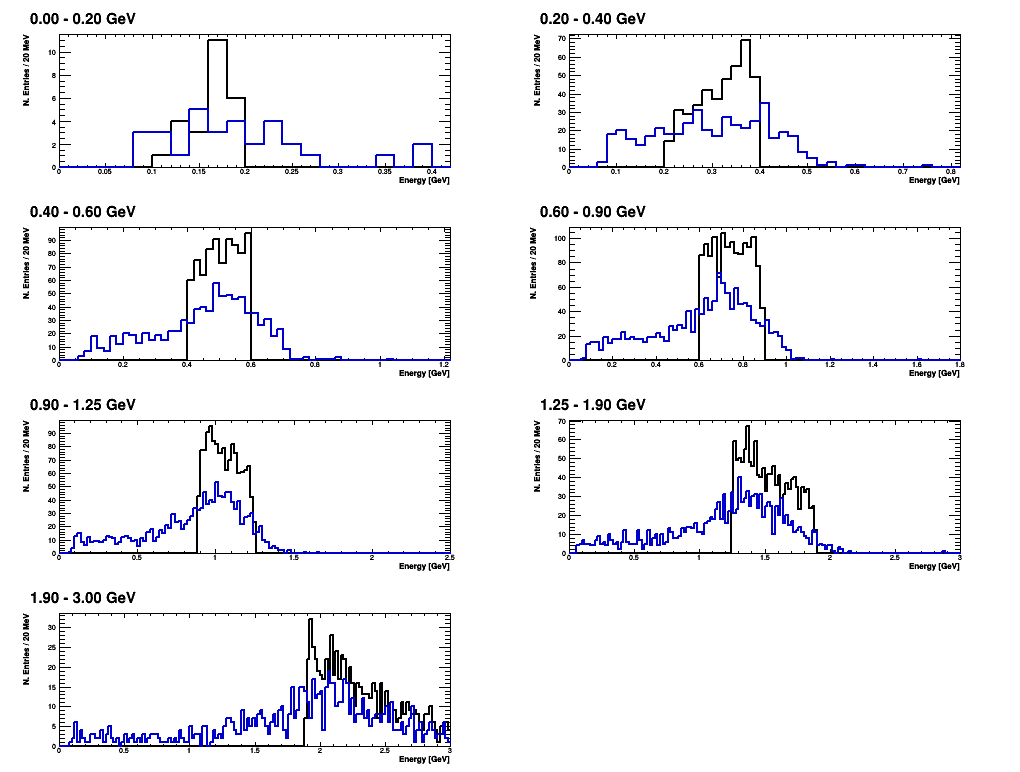

In [24]:
bins = array("f", [0, 0.2, 0.4, 0.6, 0.9, 1.25, 1.9, 3])
bins_plot = array("f", [0, 0.2, 0.4, 0.6, 0.9, 1.25, 1.9, 2.5])

c_true = ROOT.TCanvas("c_true", "True distributions", 1024, 800)
c_true.Divide(2, 4)
histos = []
h_migration = ROOT.TH2F("h_migration", ";E_{k} [GeV];E_{corr} [GeV]",
                        len(bins) - 1, bins_plot,
                        len(bins) - 1, bins_plot)
for i_bin in range(len(bins[:-1])):
    c_true.cd(i_bin + 1)
    ROOT.gPad.SetTopMargin(0.15)
    bin_l = h_true_tot.FindBin(bins[i_bin])
    bin_h = h_true_tot.FindBin(bins[i_bin + 1])
    h_true_slice = h_true_tot.Clone()

    for j_bin in range(1, h_true_tot.GetNbinsX() + 1):
        if not bin_l <= j_bin < bin_h:
            h_true_slice.SetBinContent(j_bin, 0)
    ROOT.gStyle.SetOptTitle(1)
    h_true_slice.SetTitle("%.2f - %.2f GeV;Energy [GeV];N. Entries / 20 MeV" % (bins[i_bin], bins[i_bin+1]))
    h_reco_bin = h_reco_true_corr.ProjectionY("h_reco%i" % i_bin, bin_l, bin_h)
    h_true_slice_drawn = h_true_slice.Clone()
    h_true_slice_drawn.Rebin()
    ROOT.gStyle.SetTitleFontSize(0.1)
    h_true_slice_drawn.Draw("same")
    h_true_slice_drawn.GetXaxis().SetRangeUser(0, min(3,bins[i_bin+1]*2))
    h_true_slice_drawn.SetLineColor(1)
    h_reco_bin_drawn = h_reco_bin.Clone()
    h_reco_bin_drawn.Rebin()
    h_reco_bin_drawn.Draw("same")
#     h_reco_bin.Rebin()
    histos.append(h_true_slice)
    histos.append(h_reco_bin)
    for k_bin in range(len(bins[:-1])):
        bin_l_k = h_true_tot.FindBin(bins[k_bin])
        bin_h_k = h_true_tot.FindBin(bins[k_bin + 1])
        if h_reco_bin.Integral():
            h_migration.SetBinContent(
                i_bin + 1, k_bin + 1,
                h_reco_bin.Integral(bin_l_k, bin_h_k - 1) / h_reco_bin.Integral())
# h_true_slice.SetLineColor(ROOT.kGreen)
c_true.Draw()

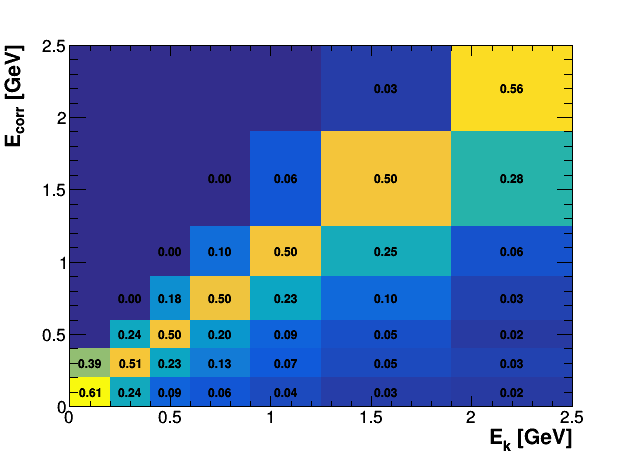

In [25]:
c_migration = ROOT.TCanvas("c_migration", "Migration matrix", 640, 480)
ROOT.gStyle.SetPaintTextFormat(".2f")
h_migration.Draw("col text")
h_migration.SetMinimum(-0.001)
h_migration.SetMaximum(0.6)
h_migration.SetMarkerSize(1.4)
c_migration.SetLeftMargin(0.11)
c_migration.Draw()